In [7]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import feature
from skimage import filters
from skimage.io import imread
from skimage.transform import resize
import scipy
from sklearn.model_selection import train_test_split

import pix2pix

In [2]:
path_root = os.path.abspath(os.path.expanduser('./Dataset/20210410-LabelMeDataset/voc/SegmentationClass'))
queue = [path_root]
npy_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.npy'):
            npy_items.append(entry.path)
npy_items.sort()
print(f'Loaded: {len(npy_items)} files')

Loaded: 300 files


In [3]:
path_root = os.path.abspath(os.path.expanduser('./Dataset/20210410-LabelMeDataset/voc/JPEGImages'))
queue = [path_root]
jpg_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.jpg'):
            jpg_items.append(entry.path)
jpg_items.sort()
print(f'Loaded: {len(jpg_items)} files')

Loaded: 300 files


In [4]:
def preprocess(path):
    data = np.load(path)
    data = resize(data, (128, 128), anti_aliasing=False)
    data = np.round(data/np.max(data))
    data[data > 0] = data[data > 0] + 1 # Class label + 1
    edge = filters.sobel(data) # Find edge
    data[edge > 0] = 1 # Set class 1 to edge
    return data

In [9]:
X = list()
y = list()
for train, label in zip(jpg_items, npy_items):
    t = imread(train)
    t = resize(t, (128, 128), anti_aliasing=True)
    X.append(t)
    l = np.expand_dims(preprocess(label), axis=-1)
    y.append(l)

In [10]:
test_size = 0.2
random_state = None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
OUTPUT_CHANNELS = 3

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

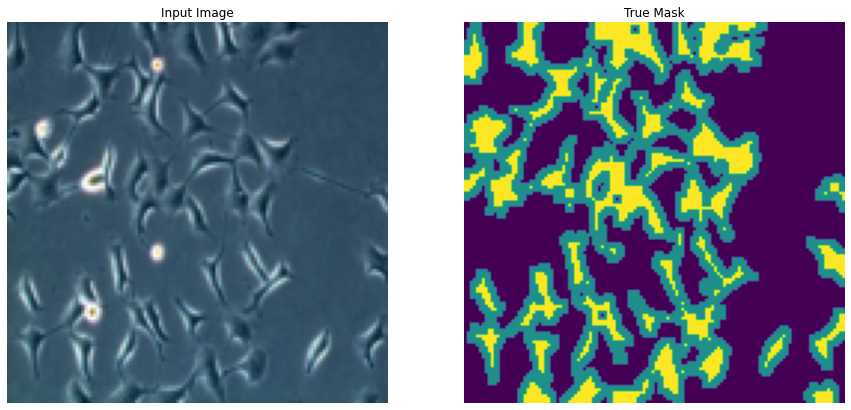

In [17]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

In [18]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
                   output_channels, 3, strides=2,
                   padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([x[0], y[0],
                 create_mask(model.predict(x[0][tf.newaxis, ...]))])

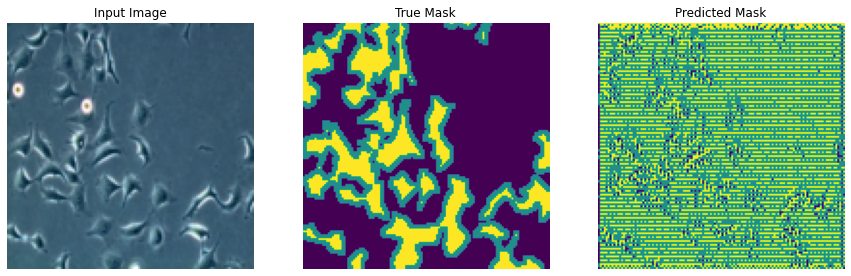

In [22]:
show_predictions()

In [23]:
CALLBACKTERM = 10
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % CALLBACKTERM == 0:
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/100
8/8 [==============================] - 9s 861ms/step - loss: 1.0599 - accuracy: 0.4505 - val_loss: 0.7036 - val_accuracy: 0.7194


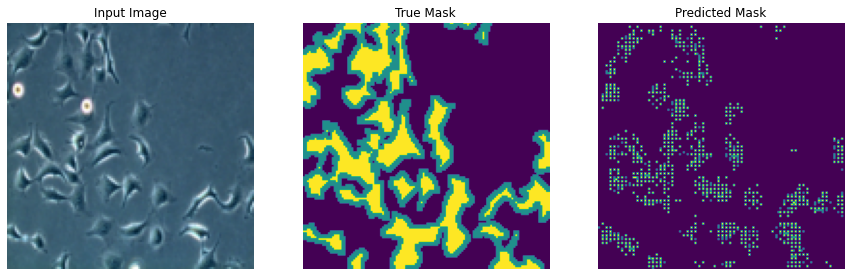


Sample Prediction after epoch 1

Epoch 2/100
8/8 [==============================] - 6s 822ms/step - loss: 0.6217 - accuracy: 0.7353 - val_loss: 0.5707 - val_accuracy: 0.7675
Epoch 3/100
8/8 [==============================] - 6s 799ms/step - loss: 0.4679 - accuracy: 0.7969 - val_loss: 0.5083 - val_accuracy: 0.8092
Epoch 4/100
8/8 [==============================] - 7s 855ms/step - loss: 0.4015 - accuracy: 0.8346 - val_loss: 0.4466 - val_accuracy: 0.8311
Epoch 5/100
8/8 [==============================] - 7s 855ms/step - loss: 0.3823 - accuracy: 0.8421 - val_loss: 0.3882 - val_accuracy: 0.8458
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 0.3353 - accuracy: 0.8634 - val_loss: 0.3695 - val_accuracy: 0.8498
Epoch 7/100
8/8 [==============================] - 11s 1s/step - loss: 0.3347 - accuracy: 0.8619 - val_loss: 0.3590 - val_accuracy: 0.8529
Epoch 8/100
8/8 [==============================] - 10s 1s/step - loss: 0.3195 - accuracy: 0.8674 - val_loss: 0.3550 - val_ac

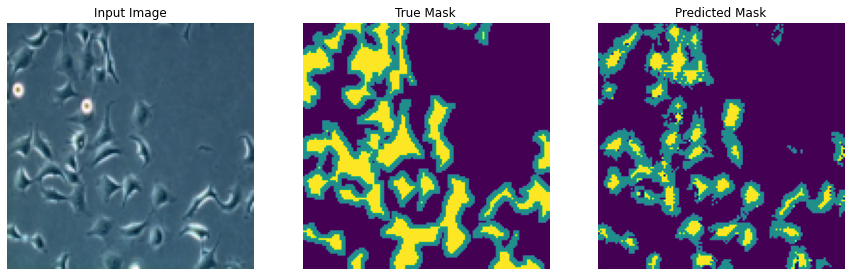


Sample Prediction after epoch 11

Epoch 12/100
8/8 [==============================] - 9s 1s/step - loss: 0.3053 - accuracy: 0.8721 - val_loss: 0.3707 - val_accuracy: 0.8354
Epoch 13/100
8/8 [==============================] - 9s 1s/step - loss: 0.2978 - accuracy: 0.8752 - val_loss: 0.3870 - val_accuracy: 0.8276
Epoch 14/100
8/8 [==============================] - 9s 1s/step - loss: 0.2702 - accuracy: 0.8867 - val_loss: 0.3675 - val_accuracy: 0.8367
Epoch 15/100
8/8 [==============================] - 9s 1s/step - loss: 0.2799 - accuracy: 0.8841 - val_loss: 0.3680 - val_accuracy: 0.8372
Epoch 16/100
8/8 [==============================] - 8s 968ms/step - loss: 0.2782 - accuracy: 0.8835 - val_loss: 0.3940 - val_accuracy: 0.8272
Epoch 17/100
8/8 [==============================] - 7s 921ms/step - loss: 0.2805 - accuracy: 0.8817 - val_loss: 0.3981 - val_accuracy: 0.8254
Epoch 18/100
8/8 [==============================] - 7s 922ms/step - loss: 0.2619 - accuracy: 0.8903 - val_loss: 0.3829 - val_

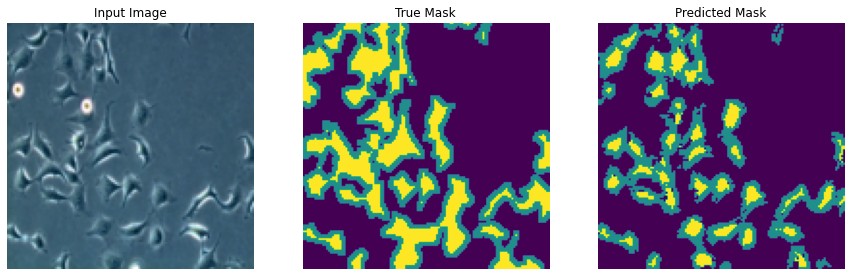


Sample Prediction after epoch 21

Epoch 22/100
8/8 [==============================] - 9s 1s/step - loss: 0.2465 - accuracy: 0.8967 - val_loss: 0.3750 - val_accuracy: 0.8401
Epoch 23/100
8/8 [==============================] - 8s 972ms/step - loss: 0.2438 - accuracy: 0.8978 - val_loss: 0.3547 - val_accuracy: 0.8484
Epoch 24/100
8/8 [==============================] - 8s 947ms/step - loss: 0.2394 - accuracy: 0.8998 - val_loss: 0.3402 - val_accuracy: 0.8541
Epoch 25/100
8/8 [==============================] - 8s 949ms/step - loss: 0.2509 - accuracy: 0.8947 - val_loss: 0.3837 - val_accuracy: 0.8382
Epoch 26/100
8/8 [==============================] - 8s 974ms/step - loss: 0.2439 - accuracy: 0.8974 - val_loss: 0.3601 - val_accuracy: 0.8467
Epoch 27/100
8/8 [==============================] - 8s 999ms/step - loss: 0.2325 - accuracy: 0.9026 - val_loss: 0.3597 - val_accuracy: 0.8495
Epoch 28/100
8/8 [==============================] - 8s 949ms/step - loss: 0.2339 - accuracy: 0.9018 - val_loss: 0.36

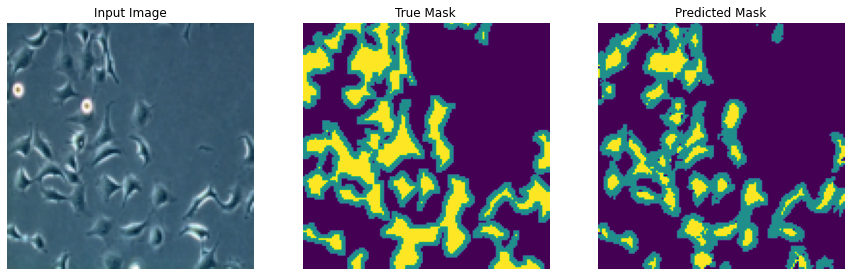


Sample Prediction after epoch 31

Epoch 32/100
8/8 [==============================] - 8s 958ms/step - loss: 0.2085 - accuracy: 0.9133 - val_loss: 0.3296 - val_accuracy: 0.8638
Epoch 33/100
8/8 [==============================] - 8s 989ms/step - loss: 0.2035 - accuracy: 0.9156 - val_loss: 0.3246 - val_accuracy: 0.8649
Epoch 34/100
8/8 [==============================] - 7s 912ms/step - loss: 0.2020 - accuracy: 0.9168 - val_loss: 0.3323 - val_accuracy: 0.8642
Epoch 35/100
8/8 [==============================] - 7s 912ms/step - loss: 0.1972 - accuracy: 0.9186 - val_loss: 0.3230 - val_accuracy: 0.8672
Epoch 36/100
8/8 [==============================] - 7s 920ms/step - loss: 0.2004 - accuracy: 0.9171 - val_loss: 0.3377 - val_accuracy: 0.8631
Epoch 37/100
8/8 [==============================] - 8s 975ms/step - loss: 0.1882 - accuracy: 0.9226 - val_loss: 0.3486 - val_accuracy: 0.8607
Epoch 38/100
8/8 [==============================] - 7s 919ms/step - loss: 0.1837 - accuracy: 0.9247 - val_loss: 0

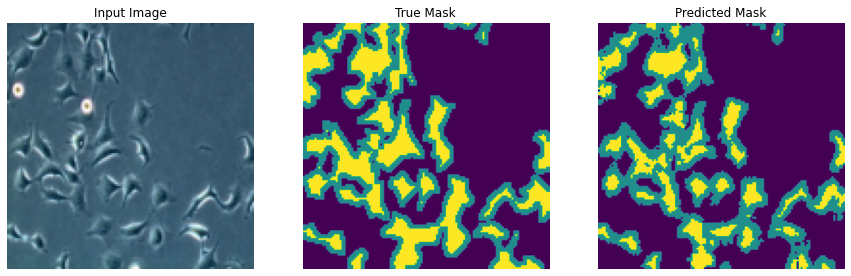


Sample Prediction after epoch 41

Epoch 42/100
8/8 [==============================] - 9s 1s/step - loss: 0.1752 - accuracy: 0.9284 - val_loss: 0.3548 - val_accuracy: 0.8634
Epoch 43/100
8/8 [==============================] - 8s 1s/step - loss: 0.1971 - accuracy: 0.9182 - val_loss: 0.3263 - val_accuracy: 0.8707
Epoch 44/100
8/8 [==============================] - 8s 1s/step - loss: 0.1803 - accuracy: 0.9260 - val_loss: 0.3300 - val_accuracy: 0.8703
Epoch 45/100
8/8 [==============================] - 8s 1s/step - loss: 0.1652 - accuracy: 0.9332 - val_loss: 0.3608 - val_accuracy: 0.8632
Epoch 46/100
8/8 [==============================] - 7s 933ms/step - loss: 0.1651 - accuracy: 0.9327 - val_loss: 0.3356 - val_accuracy: 0.8708
Epoch 47/100
8/8 [==============================] - 8s 948ms/step - loss: 0.1562 - accuracy: 0.9370 - val_loss: 0.3546 - val_accuracy: 0.8670
Epoch 48/100
8/8 [==============================] - 8s 1s/step - loss: 0.1498 - accuracy: 0.9395 - val_loss: 0.3485 - val_acc

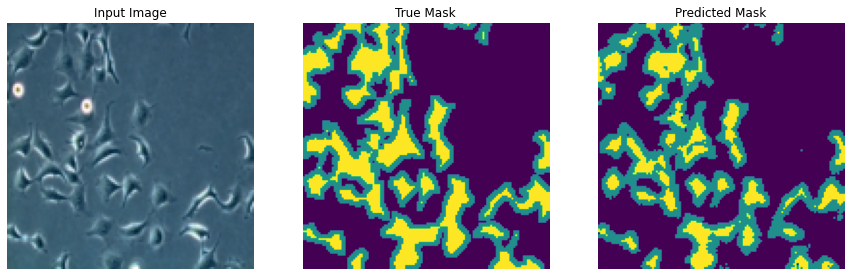


Sample Prediction after epoch 51

Epoch 52/100
8/8 [==============================] - 9s 1s/step - loss: 0.1519 - accuracy: 0.9382 - val_loss: 0.3604 - val_accuracy: 0.8655
Epoch 53/100
8/8 [==============================] - 10s 1s/step - loss: 0.1433 - accuracy: 0.9420 - val_loss: 0.3540 - val_accuracy: 0.8675
Epoch 54/100
8/8 [==============================] - 9s 1s/step - loss: 0.1399 - accuracy: 0.9441 - val_loss: 0.3690 - val_accuracy: 0.8659
Epoch 55/100
8/8 [==============================] - 10s 1s/step - loss: 0.1389 - accuracy: 0.9440 - val_loss: 0.3529 - val_accuracy: 0.8681
Epoch 56/100
8/8 [==============================] - 8s 999ms/step - loss: 0.1428 - accuracy: 0.9430 - val_loss: 0.3685 - val_accuracy: 0.8652
Epoch 57/100
8/8 [==============================] - 7s 926ms/step - loss: 0.1432 - accuracy: 0.9423 - val_loss: 0.3670 - val_accuracy: 0.8691
Epoch 58/100
8/8 [==============================] - 8s 979ms/step - loss: 0.1252 - accuracy: 0.9504 - val_loss: 0.3667 - va

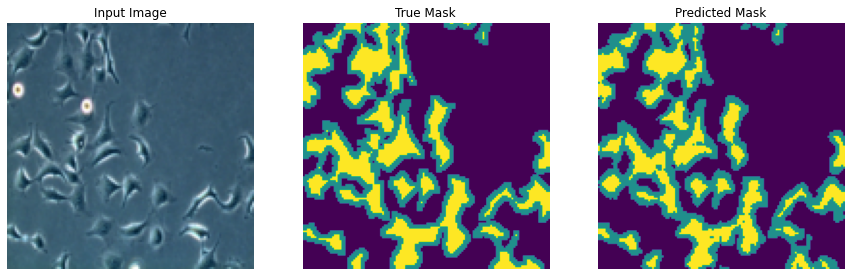


Sample Prediction after epoch 61

Epoch 62/100
8/8 [==============================] - 9s 1s/step - loss: 0.1138 - accuracy: 0.9554 - val_loss: 0.3862 - val_accuracy: 0.8662
Epoch 63/100
8/8 [==============================] - 9s 1s/step - loss: 0.1216 - accuracy: 0.9517 - val_loss: 0.3892 - val_accuracy: 0.8669
Epoch 64/100
8/8 [==============================] - 8s 980ms/step - loss: 0.1176 - accuracy: 0.9533 - val_loss: 0.4039 - val_accuracy: 0.8659
Epoch 65/100
8/8 [==============================] - 9s 1s/step - loss: 0.1173 - accuracy: 0.9535 - val_loss: 0.4051 - val_accuracy: 0.8662
Epoch 66/100
8/8 [==============================] - 10s 1s/step - loss: 0.1069 - accuracy: 0.9585 - val_loss: 0.3973 - val_accuracy: 0.8660
Epoch 67/100
8/8 [==============================] - 10s 1s/step - loss: 0.1017 - accuracy: 0.9606 - val_loss: 0.3913 - val_accuracy: 0.8661
Epoch 68/100
8/8 [==============================] - 8s 1s/step - loss: 0.1099 - accuracy: 0.9574 - val_loss: 0.4232 - val_accu

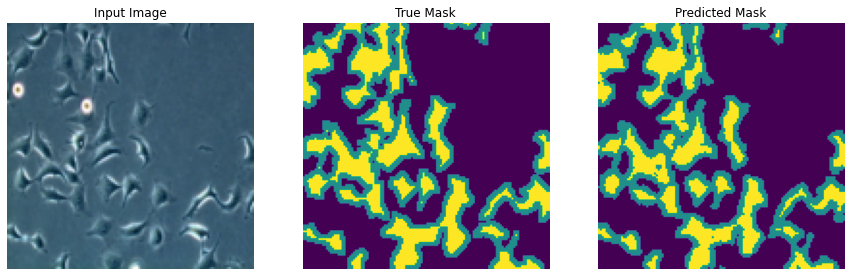


Sample Prediction after epoch 71

Epoch 72/100
8/8 [==============================] - 9s 1s/step - loss: 0.0952 - accuracy: 0.9639 - val_loss: 0.4298 - val_accuracy: 0.8636
Epoch 73/100
8/8 [==============================] - 8s 1s/step - loss: 0.0966 - accuracy: 0.9623 - val_loss: 0.4251 - val_accuracy: 0.8627
Epoch 74/100
8/8 [==============================] - 9s 1s/step - loss: 0.0961 - accuracy: 0.9629 - val_loss: 0.4271 - val_accuracy: 0.8642
Epoch 75/100
8/8 [==============================] - 8s 986ms/step - loss: 0.0964 - accuracy: 0.9630 - val_loss: 0.4447 - val_accuracy: 0.8637
Epoch 76/100
8/8 [==============================] - 8s 1s/step - loss: 0.0957 - accuracy: 0.9632 - val_loss: 0.4470 - val_accuracy: 0.8633
Epoch 77/100
8/8 [==============================] - 10s 1s/step - loss: 0.0903 - accuracy: 0.9653 - val_loss: 0.4511 - val_accuracy: 0.8623
Epoch 78/100
8/8 [==============================] - 13s 2s/step - loss: 0.0932 - accuracy: 0.9640 - val_loss: 0.4599 - val_accu

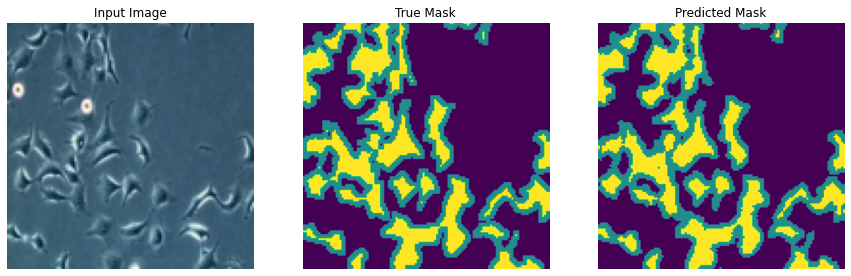


Sample Prediction after epoch 81

Epoch 82/100
8/8 [==============================] - 9s 1s/step - loss: 0.0924 - accuracy: 0.9641 - val_loss: 0.4562 - val_accuracy: 0.8620
Epoch 83/100
8/8 [==============================] - 8s 1s/step - loss: 0.0903 - accuracy: 0.9650 - val_loss: 0.4670 - val_accuracy: 0.8609
Epoch 84/100
8/8 [==============================] - 8s 1s/step - loss: 0.0845 - accuracy: 0.9677 - val_loss: 0.4698 - val_accuracy: 0.8606
Epoch 85/100
8/8 [==============================] - 9s 1s/step - loss: 0.0856 - accuracy: 0.9672 - val_loss: 0.4754 - val_accuracy: 0.8613
Epoch 86/100
8/8 [==============================] - 9s 1s/step - loss: 0.0815 - accuracy: 0.9692 - val_loss: 0.4794 - val_accuracy: 0.8614
Epoch 87/100
8/8 [==============================] - 8s 1s/step - loss: 0.0810 - accuracy: 0.9690 - val_loss: 0.4815 - val_accuracy: 0.8603
Epoch 88/100
8/8 [==============================] - 9s 1s/step - loss: 0.0759 - accuracy: 0.9717 - val_loss: 0.4801 - val_accuracy:

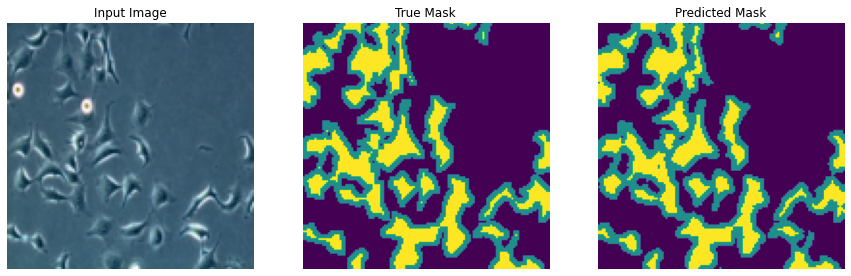


Sample Prediction after epoch 91

Epoch 92/100
8/8 [==============================] - 9s 1s/step - loss: 0.0711 - accuracy: 0.9736 - val_loss: 0.5022 - val_accuracy: 0.8593
Epoch 93/100
8/8 [==============================] - 9s 1s/step - loss: 0.0671 - accuracy: 0.9755 - val_loss: 0.5030 - val_accuracy: 0.8594
Epoch 94/100
8/8 [==============================] - 8s 1s/step - loss: 0.0700 - accuracy: 0.9742 - val_loss: 0.5181 - val_accuracy: 0.8608
Epoch 95/100
8/8 [==============================] - 8s 1s/step - loss: 0.0690 - accuracy: 0.9746 - val_loss: 0.5156 - val_accuracy: 0.8596
Epoch 96/100
8/8 [==============================] - 8s 1s/step - loss: 0.0689 - accuracy: 0.9750 - val_loss: 0.5274 - val_accuracy: 0.8598
Epoch 97/100
8/8 [==============================] - 8s 1s/step - loss: 0.0650 - accuracy: 0.9763 - val_loss: 0.5270 - val_accuracy: 0.8585
Epoch 98/100
8/8 [==============================] - 8s 1s/step - loss: 0.0645 - accuracy: 0.9766 - val_loss: 0.5334 - val_accuracy:

In [24]:
EPOCHS = 100

# model_history = model.fit(train_dataset, epochs=EPOCHS,
#                           callbacks=[DisplayCallback()])
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

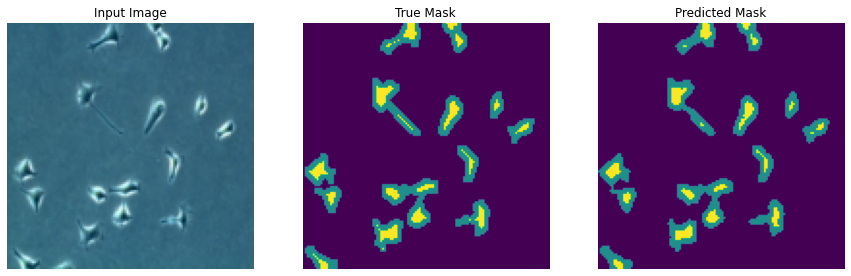

In [37]:
IDX = 15
r = model.predict(np.expand_dims(x[IDX], axis=0))
display([x[IDX], y[IDX], create_mask(r)])